In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import bears as br
import fstats
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
%matplotlib inline
rng = np.random.seed(1)

In [2]:
X = {}
y = {}
Tools = {}

# Read in match histories (going back to 2005)
X['raw'], y['raw'], dates = fstats.data_(build=False)

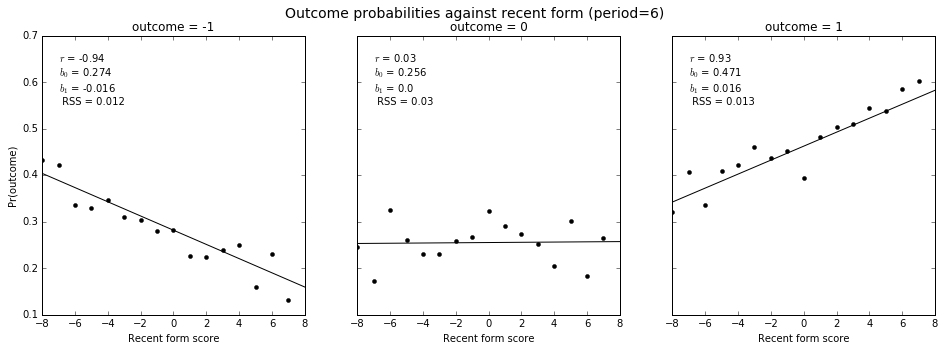

In [3]:
# Drop null values
X['raw'].dropna(inplace=True)
y['raw'].drop(y['raw'].index.drop(X['raw'].index), inplace=True)

# Split into training and testing data
X['train'], X['test'], y['train'], y['test'] = train_test_split(X['raw'], y['raw'], random_state=0)

# Remove observations that aren't within the 90th percentile
lower_bound = X['train'].quantile(q=0.05).values[0]
upper_bound = X['train'].quantile(q=0.95).values[0]
retained_values = (X['train'].recent_form > lower_bound) & (X['train'].recent_form < upper_bound)
X['train'] = X['train'].loc[retained_values, :]
y['train'] = y['train'].loc[retained_values]

# Join training observations and outcomes
Xy = X['train'].join(y['train'])

# Get outcome probabilities for each recent form score
def outcome_p(df):
    return pd.Series(df['outcome'].value_counts()/df.shape[0], name='outcome')
pmf = Xy.groupby('recent_form').apply(outcome_p)

# Convert pmf into something more usable
dx = pd.DataFrame(columns=[-1, 0, 1])
row = pd.Series()
for score in pmf.index.levels[0]:
    row.name = score
    for outcome in pmf.loc[score].index:
        row[outcome] = pmf.loc[score, outcome]
    dx = dx.append(row)

# Perform linear regression of Pr(outcome) onto recent form scores
m = {i:scipy.stats.linregress(x=dx.index, y=dx[i]) for i in [-1, 0, 1]}

# Compute residual sum of squares
RSS = {}
for i in [-1, 0, 1]:
    RSS[i] = np.square((dx[i] - (m[i].intercept + m[i].slope*dx.index))).sum()

# Plot results
f, sp = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(16, 5))
for i in [-1, 0, 1]:
    sp[i+1].plot(dx.index, dx[i], marker='o', linestyle='', color='k', markersize=4)
    yl = [m[i].intercept + m[i].slope*min(dx.index),
          m[i].intercept + m[i].slope*max(dx.index)]
    sp[i+1].plot([-8, 8], yl, color='k')
    linreg_info = ('$r$ = ' + str(round(m[i].rvalue, 2)) + '\n$b_0$ = '
                   + str(round(m[i].intercept, 3)) + '\n$b_1$ = '
                   + str(round(m[i].slope, 3)) + '\n RSS = '
                   + str(round(RSS[i], 3)))
    sp[i+1].text(-7, 0.55, s=linreg_info)
    sp[i+1].set(title='outcome = '+str(i), xlabel='Recent form score')
sp[0].set(ylabel='Pr(outcome)')
f.suptitle("Outcome probabilities against recent form (period=6)", size=14)
plt.show()

In [21]:
np.sqrt(RSS[-1]/16)

0.027658441691160083

In [8]:
def evaluate_(f, o, b, dates, bankroll=1):
    bankroll = [bankroll]
    for date in dates.unique():
        winnings = 0
        match_ix = dates.loc[dates==date].index
        rel_ix = [i for i in match_ix if i in o]
        if len(rel_ix) != 0:
            split_bankroll = bankroll[-1]/len(rel_ix)
            home_bet = f.loc[rel_ix, 'Home']*split_bankroll
            away_bet = f.loc[rel_ix, 'Away']*split_bankroll
        for i in rel_ix:
            if o.ix[i] == 1:
                winnings = winnings + home_bet.ix[i]*(b.loc[i, 'Home'] - 1) - away_bet.ix[i]
            elif o.ix[i] == -1:
                winnings = winnings + away_bet.ix[i]*(b.loc[i, 'Away'] - 1) - home_bet.ix[i]
            else:
                winnings = winnings - home_bet.ix[i] - away_bet.ix[i]
        bankroll.append(bankroll[-1] + winnings)
    return bankroll

In [5]:
def kelly(b, p):
    numerator = p.values*b.values - 1
    denominator = (p.values+1)*b.values
    kelly_raw = numerator/denominator
    kelly =  pd.DataFrame(kelly_raw.clip(min=0), index=p.index, columns=['Home', 'Away'])
    return kelly

In [6]:
def linreg_fair_odds(m, X):
    home_pr = np.array([(m[1].intercept + score[0]*m[1].slope) for _, score in X.iterrows()])
    away_pr = np.array([1/(m[-1].intercept + score[0]*m[-1].slope) for _, score in X.iterrows()])
    home_odds = np.divide(home_pr, home_pr)
    away_odds = np.divide(away_pr, away_pr)
    p = pd.DataFrame({'Home':home_odds, 'Away':away_odds}, index=X.index)
    return p

In [10]:
# Get bookmaker odds
b = fstats.odds_().loc[X['train'].index]

# Calculate Kelly fraction on bets using estimated fair odds
p = linreg_fair_odds(m, X['train'])
kelly_f = kelly(b, p)

# Manufacture dummy fractions
dummy_raw = np.random.rand(X['train'].shape[0], 2)/2
dummy_f = pd.DataFrame(dummy_raw, index=p.index, columns=['Home', 'Away'])

# Evaluate betting strategy against training set
kelly_history = evaluate_(kelly_f, y['train'], b, dates, bankroll=100)
dummy_history = evaluate_(dummy_f, y['train'], b, dates, bankroll=100)

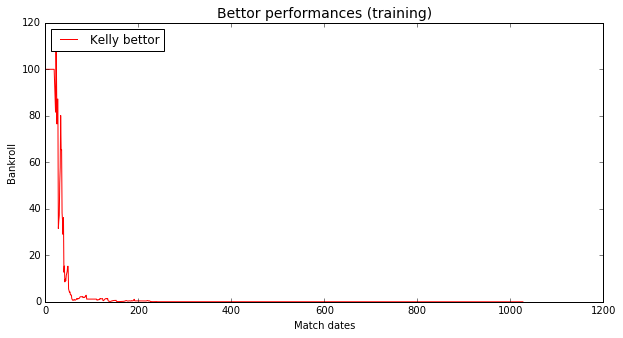

In [11]:
# Plot results
plt.figure(figsize=(10,5))
plt.plot(kelly_history, color='r',
         linestyle='-', marker='', markersize=2, label='Kelly bettor');
#plt.plot(dummy_history, color='k',
 #        linestyle='-', marker='', markersize=2, label='Random bettor');
plt.title('Bettor performances (training)', size=14)
plt.xlabel('Match dates')
plt.ylabel('Bankroll')
plt.legend(loc=2);